# Assignment 3: Creating a WordyPy Solver

You now understand the rules of _WordyPy_ and how to read the game state from an image. Now your job is to read in a
_WordyPy_ partial play and provide a next **good** guess. What's a good guess? A good guess is one which:

1. Continues to adhere to the rules of _WordPy_
2. Does not repeat words which have already been played
3. Uses the knowledge of previous guesses to pick a new good word

Unlike previous assignments there are no guardrails for this task -- you can complete this using whatever software
architecture you like! In addition, I've put my code in a new module for you to import, called `wordy`. You can just
import this module and begin making calls to it. You should be able to understand how it works by reading the module
documentation.


In [8]:
    
import numpy as np

class DisplaySpecification:
    """A dataclass for holding display specifications for WordyPy. The following
    values are defined:
        - block_width: the width of each character in pixels
        - block_height: the height of each character in pixels
        - correct_location_color: the hex code to color the block when it is correct
        - incorrect_location_color: the hex code to color the block when it is in the wrong location but exists in the string
        - incorrect_color: the hex code to color the block when it is not in the string
        - space_between_letters: the amount of padding to put between characters, in pixels
        - word_color: the hex code of the background color of the string
    """

    block_width: int = 80
    block_height: int = 80
    correct_location_color: str = "#00274C"
    incorrect_location_color: str = "#FFCB05"
    incorrect_color: str = "#D3D3D3"
    space_between_letters: int = 5
    word_color: str = "#FFFFFF"
    
# Create the implementation of the Letter class here
class Letter:
    def __init__(self, letter):
        self.letter = letter
        self.in_correct_place = False
        self.in_word = False
        
    def is_in_correct_place(self):
        return self.in_correct_place
    def is_in_word(self):
        return self.in_word
    
    def __str__(self):
        return f'{self.letter}  {self.is_in_correct_place()}  {self.is_in_word()}'
    
class Bot:
    def __init__(self, word_list_file, display_spec):
        try: 
            with open(word_list_file, 'r') as f:
                self.word_list = f.read().split('\n')
                self.word_list = [word.upper() for word in self.word_list]

                # print(f'List of word: {self.word_list}')
                # print(self.word_list)
            self.display_spec = display_spec
        except Exception as e: 
            print(f'Exception: {e}')
            
    def _tuple_to_str(self, pixels):
        return '#{:02x}{:02x}{:02x}'.format(*pixels[:3]).upper()
    
    def _process_image(self, guess, guess_image):
        # Getting image shape
        img_array = np.array(guess_image, dtype=np.uint8)
        letter_img_size = img_array.shape[1] // 5
        letter_img_mid = letter_img_size // 2
        
        guess_results = list()
        for i in range(5):
            hex_code = self._tuple_to_str((img_array[0][letter_img_mid + letter_img_size * i][0],
                                             img_array[0][letter_img_mid + letter_img_size * i][1],
                                             img_array[0][letter_img_mid + letter_img_size * i][2]
                                          ))
            
            letter = Letter(guess[i])
            if self.display_spec.correct_location_color == hex_code:
                letter.in_correct_place = True
                letter.in_word = True
            elif self.display_spec.incorrect_location_color == hex_code:
                letter.in_correct_place = False
                letter.in_word = True
            else:
                letter.in_correct_place = False
                letter.in_word = False
            guess_results.append(letter)
            
        print(f' ***** Guess Results *****')
        print('L  Place Word')
        for x in guess_results:
            print(x)
        print('*' * 10)
        return guess_results
    
    def make_guess(self):        
        import random
        return self.word_list[random.randint(0, len(self.word_list)-1)]
    
    def remove_word(self, word):
        if word in self.word_list:
            self.word_list.remove(word)
    
    def record_guess_results(self, guess, guess_image):   
        guess_results = self._process_image(guess, guess_image)
        
        if guess in self.word_list:
            self.word_list.remove(guess)
        elif guess.lower() in self.word_list:
            self.word_list.remove(guess.lower())
        
        # IS NOT IN WORD
        absent_in_word = [letterObj.letter for letterObj in guess_results if letterObj.is_in_word() is False]
        # print(f'Absent in word: {absent_in_word}')

        new_word_list = []
        for word in self.word_list:
            flag = True
            for char in absent_in_word:
                if char in word:
                    flag = False
                    break
            if flag:
                new_word_list.append(word)
        # print(f'New word list: {new_word_list}')

        # IS IN CORRECT PLACE
        correct_place_word = {}
        for i in range(0, len(guess_results)):
            if guess_results[i].is_in_correct_place() is True:
                correct_place_word[guess_results[i].letter] = i

        final_list = []
        for word in new_word_list:
            if len(word) >= 5:
                flag = True
                for key, value in correct_place_word.items():
                    if word[value] != key:
                        flag = False
                        break
                if flag:
                    final_list.append(word)
        self.word_list = final_list
        # print(f'Final list: {self.word_list}')
        

In [9]:
import wordy
import PIL
import numpy as np

def crop_images(image):
    display(image)

    # print(f' **** Crop Image ****')
    # Counting guesses
    guesses = image.height // 60
    
    # Cropping image
    left, upper, right, lower = 0, 0, image.width, 60
    
    image_list = []
    for i in range(guesses):
        # left, upper, right, lower
        
        cropped_image = image.crop([left, upper, right, lower])
        # gray_scale_image = cropped_image.convert('L')
        
        # updating row 
        upper, lower = upper + 60, lower + 60
        
        # print(f'.' * 20)
        # display(cropped_image)
        image_list.append(cropped_image)
        
    return image_list

In [10]:
def guess_string(original_image):
    # Base Image
    image = original_image.copy()
    
    import pytesseract
    # print(f'Height: {image.height}\nWidth: {image.width}')
    
    # print('******** Single Row Image ********')
    image = image.convert('L')
    # display(image)

    # Convert Image
    new_image = bytearray(image.tobytes())
    
    threshold = 250
    for location, value in enumerate(new_image):
        if value < threshold:
            new_image[location] = 0
        else:
            new_image[location] = 255
    
    new_image = PIL.Image.frombytes(image.mode, image.size, bytes(new_image))
    
    # print('******** Byte array Image ********')
    # display(new_image)

    # Removing white line between words
    # left, upper, right, lower
    left, upper, right, lower = 0, 0, 60, new_image.height
    list_im = []
    for i in range(5):
        image_char = new_image.crop([left, upper, right, lower])
        
        left = left + 60 + 5
        right = right + 60 + 5
        
        list_im.append(image_char)
    merged_image = PIL.Image.new('RGB', (300, 60))
    
    # Merging individual characters
    current_x = 0
    for image in list_im:
        merged_image.paste(image, (current_x, 0))
        current_x += image.width

    # print('******** Final Processed Image ********')
    # display(merged_image)
    string = pytesseract.image_to_string(merged_image)
    # print(f'Characters: {string}')
    
    return string[:-1]

In [11]:
def correction(words):
    new_list = []
    for word in words:
        string = ''
        for ch in word:
            if ch.isalpha():
                string = string + ch
        while len(string) < 5:
            string = string + 'A'
        new_list.append(string.upper())
        
    return new_list

In [12]:
def ocr_with_boxes(image):
    print(f' _-----_ New CALL _-----_ ')
    # Cropping guess from board image
    words_image = crop_images(image) 
    
    words = []
    for image in words_image:
        words.append(guess_string(image))
    
    print(f'Before: {words}')
    words = correction(words)
    print(f'After: {words}')
    
    b = Bot('words.txt', DisplaySpecification())
    for i in range(len(words) - 1):
        b.remove_word(words[i].lower())
    
    b.record_guess_results(words[-1], words_image[-1])
    guess = b.make_guess()
    return guess
        
#     img_array = np.array(image, dtype=np.uint8)
#     # print(f'Height: {image.height}\nWidth: {image.width}\nLast Pixel:{img_array[0][-1]}')
    
#     acopy = image.copy()
#     draw = PIL.ImageDraw.Draw(acopy)
#     import pytesseract
    
#     for line in pytesseract.image_to_data(image).splitlines()[1:]:
#         x,y,w,h,c = [float(p) for p in line.split('\t')[6:11]]
#         if c > 0:
#             draw.rectangle((x, y, x+w, y+h), outline='red', width=2)
#     # print(pytesseract.image_to_string(image))
#     return acopy

In [13]:
def solution(board: PIL.Image) -> str:
    """The student solution to the problem.

    You must write code to query the wordy module and make
    a guess for the word. You needs to inspect the module to
    understand how to do this, and this function should only return
    the guess that you are going to make based on the game board state.

    Returns:
        str: The guess that you are going to make.
    """
    new_guess = ocr_with_boxes(board)
    print(f' New Guess: {new_guess}, {len(new_guess)}')
    return new_guess

 _-----_ New CALL _-----_ 


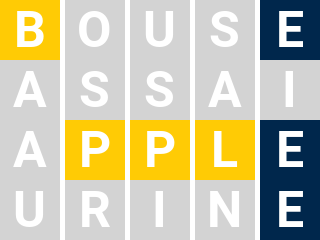

Before: ['BOUSE', 'ASSAI1', 'APPLE', 'URINE']
After: ['BOUSE', 'ASSAI', 'APPLE', 'URINE']
 ***** Guess Results *****
L  Place Word
U  False  False
R  False  False
I  False  False
N  False  False
E  True  True
**********
 New Guess: CHAPE, 5


In [14]:
for i in range(1):
    try:
        # Get an image of the current board state from wordy.
        # Note that the image contains some number of random guesses (always less than 5 guesses).
        image = wordy.get_board_state()
        # Create a new *good* guess based on the image and rules of wordy
        new_guess = solution(image)  # your code goes in solution()!
        # Send that guess to wordy to make sure it doesn't throw any errors
        wordy.make_guess(new_guess)
    except Exception as e:
        raise e

In [15]:
# def guess_string2(image):
#     import pytesseract
#     print(f'Height: {image.height}\nWidth: {image.width}')
#     display(image)
#     string = pytesseract.image_to_string(image)
#     print(string)

#     # left, upper, right, lower
#     left, upper, right, lower = 0, 0, 60, image.height
    
#     print('#'*20)
# #     image_1 = image.crop([left, upper, right, lower])
# #     display(image_1)
    
# #     image_2 = image.crop([left+60+5, upper, right+60+5, lower])
# #     display(image_2)

#     list_im = []
#     for i in range(5):
#         image_char = image.crop([left, upper, right, lower])
        
#         left = left + 60 + 5
#         right = right + 60 + 5
        
#         # image_char = image_char.resize((image_char.width*4, image_char.width*4))
#         # display(image_char)
#         # print(f'Char :{pytesseract.image_to_string(image)}') 
#         list_im.append(image_char)
        
#     total_width = 300
#     max_height = 60
#     merged_image = PIL.Image.new('RGB', (total_width, max_height))
#     current_x = 0
    
#     for image in list_im:
#         merged_image.paste(image, (current_x, 0))
#         current_x += image.width
        
#     merged_image = merged_image.convert('L')
#     display(merged_image)
#     string = pytesseract.image_to_string(merged_image)
#     print(string)
    
#     print('#'*20)


 _-----_ New CALL _-----_ 


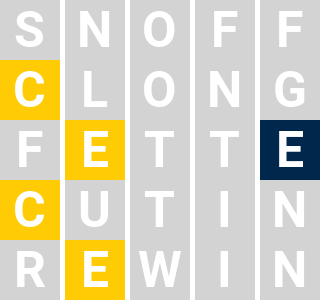

Before: ['SNOF F', 'CLONG', 'FETTE', 'CUT IN', 'REWIN']
After: ['SNOFF', 'CLONG', 'FETTE', 'CUTIN', 'REWIN']
 ***** Guess Results *****
L  Place Word
R  False  False
E  False  True
W  False  False
I  False  False
N  False  False
**********
 New Guess: EDUCT, 5
 _-----_ New CALL _-----_ 


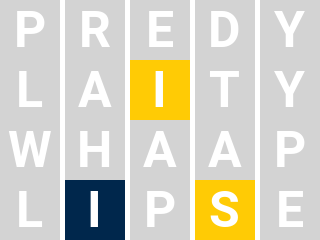

Before: ['PREDY', 'LAITY', 'WHAAP', 'L\n\nPSE']
After: ['PREDY', 'LAITY', 'WHAAP', 'LPSEA']
 ***** Guess Results *****
L  Place Word
L  False  False
P  True  True
S  False  False
E  False  True
A  False  False
**********
 New Guess: EPURE, 5
 _-----_ New CALL _-----_ 


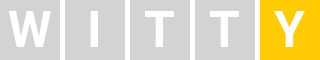

Before: ['WITTY']
After: ['WITTY']
 ***** Guess Results *****
L  Place Word
W  False  False
I  False  False
T  False  False
T  False  False
Y  False  True
**********
 New Guess: DEFER, 5
 _-----_ New CALL _-----_ 


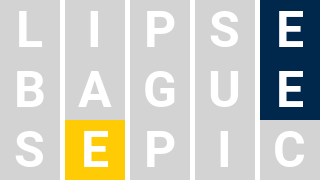

Before: ['LIPSE', 'BAGUE', 'SEPIC']
After: ['LIPSE', 'BAGUE', 'SEPIC']
 ***** Guess Results *****
L  Place Word
S  False  False
E  False  True
P  False  False
I  False  False
C  False  False
**********
 New Guess: BENDY, 5
 _-----_ New CALL _-----_ 


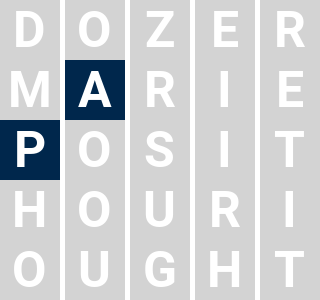

Before: ['DOZER', 'MAR 1\n\nE', 'POS IT', 'HOUR 1', 'OUGHT']
After: ['DOZER', 'MAREA', 'POSIT', 'HOURA', 'OUGHT']
 ***** Guess Results *****
L  Place Word
O  False  False
U  False  False
G  False  False
H  False  False
T  False  False
**********
 New Guess: FLEME, 5


In [17]:
# The autograder for this assignment is easy, it will try and play
# a few rounds of the game and ensure that errors are not thrown. If
# you can make it through five rounds we'll assume you have the right
# solution!
#
# You SHOULD NOT change anything in the wordy module, instead you
# must figure out how to write the solution() function in this notebook
# to make a good guess based on the board state!

for i in range(5):
    try:
        # Get an image of the current board state from wordy.
        # Note that the image contains some number of random guesses (always less than 5 guesses).
        image = wordy.get_board_state()
        # Create a new *good* guess based on the image and rules of wordy
        new_guess = solution(image)  # your code goes in solution()!
        # Send that guess to wordy to make sure it doesn't throw any errors
        wordy.make_guess(new_guess)
    except Exception as e:
        raise e